Hi boys, just playing with the facial features data for now

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from spearman import score_function

In [30]:
# read .csv using pandas
X= pd.read_csv("data/facial_features_train.csv").set_index("ID")
X_to_predict = pd.read_csv("data/facial_features_test.csv").set_index("ID")
y = pd.read_csv("data/training_outputs.csv", delimiter=";").set_index("ID")

# store id's
X_ids = np.array(X.index)
X_to_predict_ids = np.array(X_to_predict.index)

# convert to numpy array
feature_names = np.array(X.columns)
name_to_col = {feature_names[i]:i for i in range(len(feature_names))}  # gives each feature column number

# preprocessing of strings (for both X and X_predict)
for X_ in (X, X_to_predict):
    # convert age strings to integers
    X_["age"] = X_["age"].apply(lambda x: 0 if x=="None" else int(x))
    # convert gender to integers
    X_["gender"] = X_["gender"].apply(lambda a: 2*(a=='male') + 1*(a =='female') + 0*(a=='None'))
    # convert left_eye to integers
    X_["left_eye"] = X_["left_eye"].apply(lambda a: 2*(a=='opened') + 1*(a =='closed') + 0*(a=='None'))
    X_["right_eye"] = X_["right_eye"].apply(lambda a: 2*(a=='opened') + 1*(a =='closed') + 0*(a=='None'))
    # convert confidence to float between 0.5 and 1 (0 if None)
    for col in ["confidence_gender", "confidence_left_eye", "confidence_right_eye"]:
        X_[col] = X_[col].apply(lambda x: 0 if x=="None" else float(x))

X = X.as_matrix()
X_to_predict = X_to_predict.as_matrix()
y = y.as_matrix().reshape((-1,))

In [31]:
# cut into test, train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# check wich columns are numerical 
numeric_features = np.array([type(value) is not str for value in X[0,:]])

# features that are only in the training set
train_only = ['background_impact_p', 'background_impact_n','angle_impact_p', 'angle_impact_n', 
              'position_impact_p', 'position_impact_n', 'sharpness_impact_p', 'sharpness_impact_n', 
              'exposure_impact_p', 'exposure_impact_n','expression impact_p', 'expression_impact_n']
train_only = np.array([name in train_only for name in feature_names])

# To spice things up a little bit, ADABOOST

In [32]:
# for now we keep only numerical features that are also in the testing (X_to_predict) set
to_keep = (~train_only) & numeric_features

In [33]:
#ada = AdaBoostRegressor(n_estimators=100, 
#                        learning_rate=0.1, loss='linear')
clf = GradientBoostingRegressor(n_estimators=200)

In [34]:
clf.fit(X_train[:, to_keep], y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [35]:
# MSE on train and test
print("train\t", round(clf.score(X_train[:, to_keep], y_train),2))
print("test\t", round(clf.score(X_test[:, to_keep], y_test),2))

train	 0.43
test	 0.24


In [36]:
preds = clf.predict(X_test[:, to_keep])

In [37]:
score_function(y_pred=np.round(preds), y_true=y_test)

0.48764272232573247

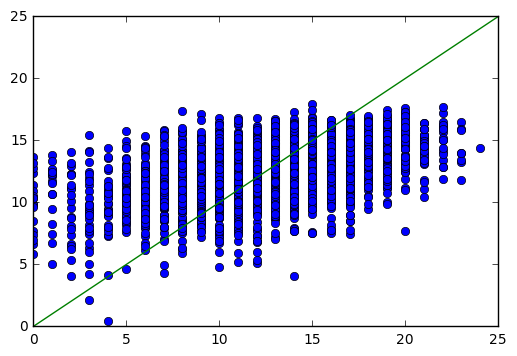

In [38]:
plt.figure()
plt.plot(y_test, preds, "o")
plt.plot([0,25], [0, 25])
plt.show()

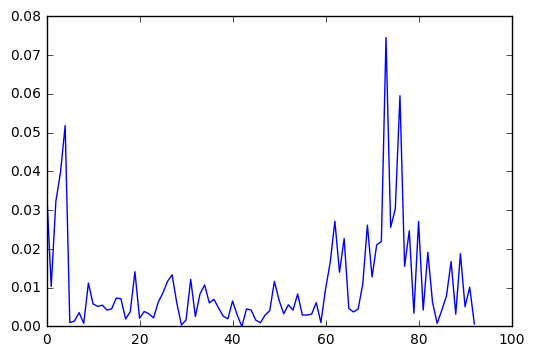

In [39]:
plt.plot(clf.feature_importances_)

In [40]:
# top ten features
print(feature_names[to_keep][np.argsort(clf.feature_importances_)[::-1]][0:10])

['landmarks confidence' 'age' 'height' 'width' 'detection score' 'y0'
 'roll angle' 'left_ear_tragion_y' 'confidence_left_eye'
 'chin_left_gonion_x']


### Submission

In [41]:
# and we can make our submission
scores_sub = clf.predict(X_to_predict[:, np.array([type(value) is not str for value in X_to_predict[0,:]])])

In [42]:
submission = np.array(np.vstack((X_to_predict_ids, np.round(scores_sub))).T, dtype=int)
submission = pd.DataFrame(submission, columns=["ID", "TARGET"])

In [43]:
name_sub = "gradientboosting_submission" + time.strftime("_%d%m_%H%M")+ ".csv"
submission.to_csv(name_sub, sep=";", index=False)